
Training Baseline Model
Epoch 1/20 - Loss: 0.1659
Epoch 2/20 - Loss: 0.0363
Epoch 3/20 - Loss: 0.0239
Epoch 4/20 - Loss: 0.0081
Epoch 5/20 - Loss: 0.0024
Epoch 6/20 - Loss: 0.0012
Epoch 7/20 - Loss: 0.0009
Epoch 8/20 - Loss: 0.0006
Epoch 9/20 - Loss: 0.0004
Epoch 10/20 - Loss: 0.0003
Epoch 11/20 - Loss: 0.0002
Epoch 12/20 - Loss: 0.0002
Epoch 13/20 - Loss: 0.0002
Epoch 14/20 - Loss: 0.0002
Epoch 15/20 - Loss: 0.0002
Epoch 16/20 - Loss: 0.0002
Epoch 17/20 - Loss: 0.0002
Epoch 18/20 - Loss: 0.0002
Epoch 19/20 - Loss: 0.0001
Epoch 20/20 - Loss: 0.0001

Training Attention Model
Epoch 1/20 - Loss: 0.1038
Epoch 2/20 - Loss: 0.0409
Epoch 3/20 - Loss: 0.0261
Epoch 4/20 - Loss: 0.0084
Epoch 5/20 - Loss: 0.0025
Epoch 6/20 - Loss: 0.0016
Epoch 7/20 - Loss: 0.0012
Epoch 8/20 - Loss: 0.0009
Epoch 9/20 - Loss: 0.0007
Epoch 10/20 - Loss: 0.0006
Epoch 11/20 - Loss: 0.0005
Epoch 12/20 - Loss: 0.0006
Epoch 13/20 - Loss: 0.0005
Epoch 14/20 - Loss: 0.0005
Epoch 15/20 - Loss: 0.0005
Epoch 16/20 - Loss: 0.

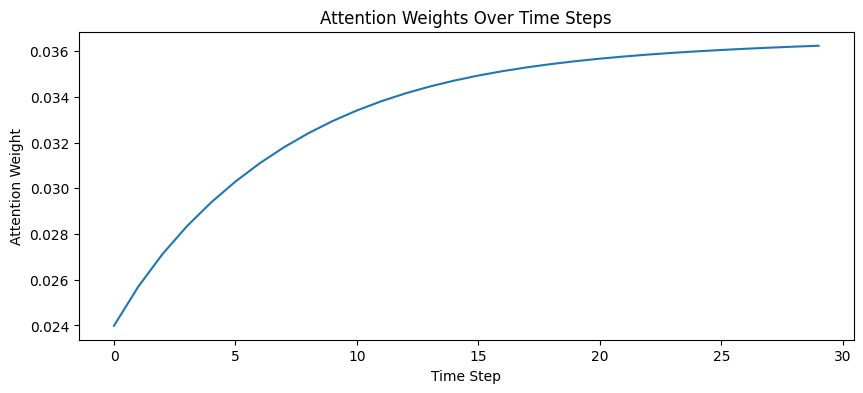

In [3]:
# ===============================
# ADVANCED TIME SERIES FORECASTING WITH ATTENTION (SINGLE CELL)
# ===============================

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

# -------------------------------
# 1. DATA GENERATION
# -------------------------------
np.random.seed(42)
torch.manual_seed(42)

n_steps = 1500
t = np.arange(n_steps)

f1 = np.sin(0.02 * t) + 0.01 * t
f2 = np.cos(0.015 * t)
f3 = 0.5 * np.sin(0.05 * t)
noise = np.random.normal(0, 0.1, n_steps)

y = f1 + f2 + noise

df = pd.DataFrame({"f1": f1, "f2": f2, "f3": f3, "y": y})

# -------------------------------
# 2. SCALING + SEQUENCE CREATION
# -------------------------------
scaler = MinMaxScaler()
scaled = scaler.fit_transform(df)

X = scaled[:, :-1]
y = scaled[:, -1]

SEQ_LEN = 30

def make_sequences(X, y, seq_len):
    xs, ys = [], []
    for i in range(len(X) - seq_len):
        xs.append(X[i:i+seq_len])
        ys.append(y[i+seq_len])
    return np.array(xs), np.array(ys)

X_seq, y_seq = make_sequences(X, y, SEQ_LEN)

split = int(0.8 * len(X_seq))
X_train, X_test = X_seq[:split], X_seq[split:]
y_train, y_test = y_seq[:split], y_seq[split:]

# -------------------------------
# 3. DATASET + DATALOADER
# -------------------------------
class TSData(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_loader = DataLoader(TSData(X_train, y_train), batch_size=64, shuffle=True)
test_loader = DataLoader(TSData(X_test, y_test), batch_size=64)

# -------------------------------
# 4. BASELINE SEQ2SEQ MODEL
# -------------------------------
class Seq2Seq(nn.Module):
    def __init__(self, input_size, hidden_size):
        super().__init__()
        self.encoder = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        _, (h, _) = self.encoder(x)
        return self.fc(h[-1])

# -------------------------------
# 5. BAHADANAU ATTENTION
# -------------------------------
class BahdanauAttention(nn.Module):
    def __init__(self, hidden_size):
        super().__init__()
        self.W1 = nn.Linear(hidden_size, hidden_size)
        self.W2 = nn.Linear(hidden_size, hidden_size)
        self.V = nn.Linear(hidden_size, 1)

    def forward(self, encoder_outputs, hidden):
        hidden = hidden.unsqueeze(1)
        score = self.V(torch.tanh(self.W1(encoder_outputs) + self.W2(hidden)))
        weights = torch.softmax(score, dim=1)
        context = torch.sum(weights * encoder_outputs, dim=1)
        return context, weights

class AttnSeq2Seq(nn.Module):
    def __init__(self, input_size, hidden_size):
        super().__init__()
        self.encoder = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.attn = BahdanauAttention(hidden_size)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        enc_out, (h, _) = self.encoder(x)
        context, attn_weights = self.attn(enc_out, h[-1])
        return self.fc(context), attn_weights

# -------------------------------
# 6. TRAINING FUNCTION
# -------------------------------
def train(model, loader, epochs=20):
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    loss_fn = nn.MSELoss()

    for ep in range(epochs):
        model.train()
        total_loss = 0

        for xb, yb in loader:
            optimizer.zero_grad()
            out = model(xb)
            if isinstance(out, tuple):
                out = out[0]
            loss = loss_fn(out.squeeze(), yb)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        print(f"Epoch {ep+1}/{epochs} - Loss: {total_loss/len(loader):.4f}")

# -------------------------------
# 7. TRAIN MODELS
# -------------------------------
baseline = Seq2Seq(input_size=3, hidden_size=64)
attn_model = AttnSeq2Seq(input_size=3, hidden_size=64)

print("\nTraining Baseline Model")
train(baseline, train_loader)

print("\nTraining Attention Model")
train(attn_model, train_loader)

# -------------------------------
# 8. EVALUATION
# -------------------------------
def evaluate(model, loader):
    model.eval()
    preds, trues = [], []

    with torch.no_grad():
        for xb, yb in loader:
            out = model(xb)
            if isinstance(out, tuple):
                out = out[0]
            preds.extend(out.squeeze().detach().numpy())
            trues.extend(yb.detach().numpy())

    rmse = np.sqrt(mean_squared_error(trues, preds))
    mae = mean_absolute_error(trues, preds)
    mape = np.mean(np.abs((np.array(trues) - np.array(preds)) / np.array(trues))) * 100
    return rmse, mae, mape

print("\nEvaluation Results")
print("Baseline (RMSE, MAE, MAPE):", evaluate(baseline, test_loader))
print("Attention (RMSE, MAE, MAPE):", evaluate(attn_model, test_loader))

# -------------------------------
# 9. ATTENTION VISUALIZATION (FIXED)
# -------------------------------
attn_model.eval()

with torch.no_grad():
    xb, _ = next(iter(test_loader))
    _, attn_weights = attn_model(xb[:1])

plt.figure(figsize=(10,4))
plt.plot(attn_weights.squeeze().detach().numpy())
plt.title("Attention Weights Over Time Steps")
plt.xlabel("Time Step")
plt.ylabel("Attention Weight")
plt.show()
